#### Making a market

Suppose you are a dealer, i.e. a market maker, offering to buy and sell an asset. You will be asked to write functions that determine the trades you engage in, and to compute some outcomes of your activities in the market. We will assume that the fair value of the asset is commonly known to be 100 and does not change. Other traders, who will be your counterparties, will want to buy or sell the asset because of some exogenous private value `pv` gained from doing so (e.g. facing a liquidity shock). The trade size is fixed at one unit of the asset. Your behaviour as a dealer will be defined in a simplistic way that does not consider any optimization of your trading activity (which would require considering the dynamics of the trading process).

1. You are first asked to write a function `prices` returning your bid and ask prices (the prices at which you are willing to buy and sell, respectively).

Your willingness to buy and sell the asset will depend on the following parameters:

* your pre-existing position `X` (called inventory) in the asset 
* a fixed cost `a` you incur for trading
* the cost you incur by holding a position in the asset, defined by the parameters `b` and `c`
    
Thus, the function needs to take the following arguments:
    
* your inventory `X`    
* parameters `a`, `b`, `c` specifying a quadratic cost function $a+b|X|+cX^2$

`b` and `c` should be optional parameters of the function and default to 0.

The function should return a tuple `(bid, ask)`, where `bid` and `ask` are determined as follows:

* $bid = 100 - a + b(|X|-|X+1|)+c(X^2 - (X+1)^2)$
* $ask = 100 + a - b(|X|-|X-1|)+c(X^2 - (X-1)^2)$

Please briefly explain why these functions "make sense", even though they are clearly not optimal.

In [4]:
import numpy as np
#Function prices returning bid and ask prices

def prices(x, a, b=0, c=0):
    bid = 100 - a + b * (abs(x) - abs(x + 1)) + c * (x**2 - (x + 1)**2)
    ask = 100 + a - b * (abs(x) - abs(x - 1)) + c * (x**2 - (x - 1)**2)
    return (bid, ask)

prices(100, 3) #bid and ask prices with inventory equal to 100 and trading cost "a" equal to 3
#The functions make sense because they disclose the costs of the dealer. The bid function shows that if the trade happens,
#he will incur cost a (which depends on the trade) in the case the dealer purchases the asset. This cost makes the trade
#less profitable, that is why it decreases the value of the asset. Costs b and c only depend on the inventory X. In the bid
#function they are multiplied with the change in the inventroy in case of the trade happening, in regard to the cost function.
#As x can only increase in the bid function, the total cost incurred by b as also by c will always be negative.
#In the ask function a is added to the asset value as else the dealer will loose money with the trade. The cost will have to
#be bared by the buyer. With the sale of the asset, the costs related to the inventory will decrease, which is why the sale
#price of the dealer decreases. The relative saved amount through the trade will therefore be deducted form the ask price,
#in regard to the cost function of the dealer.

(97, 103)

2. Before being able to compute the outcome of the trading process, the traders' private values need to be specified. To do so, write a function `private_values` taking the following arguments:

    * number of traders `N`
    * maximum of the absolute value of their private values `B`
    
The function should return a numpy array containing randomly generated private values that are uniformly distributed between `-B` and `B`.

In [5]:
def private_values(N, B): #defining function private_values after input of number of traders and max private value
    return np.random.uniform(-B, B, N)#returns random float number between min value, max value and number of values

private_values(10, 3)#pvs for 10 traders with max pv 3 and min pv -3

array([ 1.11941391,  1.29063127, -1.22892888,  2.09543665, -1.67582326,
        1.70701548, -0.69232207, -0.96147341, -2.64581491, -1.99169833])

3. The final step is to compute the outcomes of the trading process. Assume that the traders arrive in the order in which they are contained in the array obtained from 2. and that you incur your costs every round (though `a` is only incurred if a trade actually happens). Write a function `outcomes` that makes use of the functions you wrote in 1. and 2. and that returns an object containing, for each period (i.e. for each trader), the following information:

* The private value gained by the trader (0 if no trade happens)
* The dealer's cost

To do so, make the following assumptions:

* The initial inventory is 0.
* A trade happens if it is beneficial to the trader, i.e. if $100+pv<bid$, in which case you buy from the trader at the bid price, or $100+pv>ask$, in which case you sell to the trader at the ask price.

In [6]:
# N is number of traders, B is the absolute value of their private values. These values are used for the function from the Task 2.
# Values a, b, c are used for the function from the Task 1.
def outcomes(N, B, a, b=0, c=0):
    X = 0 #initial inventory = 0
    # For each trader we will return the list of private value gained and the list of the dealers costs for every interaction:
    pv_gained = []
    dealers_costs = []
    traders_pv = private_values(N, B) #the function returns the numpy array of traders' private values, which we store in a variable traders_pv
    for pv in traders_pv: # Loop for each trader in the traders_pv

        # Since our inventory may change with each additional iteration, our bid and ask price should be re-calculated each time with the new X value.
        bid_and_ask_price = prices(X, a, b, c)
        bid = bid_and_ask_price[0] #as bid_and_ask_price returns 2 different lists, we separate the bid list and the ask price list
        ask = bid_and_ask_price[1] 
        costs = b*abs(X)+c*abs(X**2) # We calculate costs without a (since we don't know yet whether the trade will happen)

        if pv < 0: # Since pv returned by the private_values function is negative, the trader wants to sell, and we need to check if we want to buy.
            if 100 + pv < bid: # Trade will happen, we buy one unit.
                X = X+1 # Our inventory increases by 1.
                pv_gained.append(abs(bid - (100 + pv))) #add the gained private value by the trader to the output list
                dealers_costs.append(costs + a) #add the cost incurred by the dealer to the second output list
            else: # Trade will not happen.
                pv_gained.append(0) # No trade happened, so nothing gained in this round. But we still need to add a 0 to the list
                dealers_costs.append(costs) # We add costs without 'a' variable, because no trade happens.
        else: # Since pv is 0 or positive, we check if there is someone who wants to buy our unit.
            if X == 0: # Trade will not happen, because we have nothing to sell.
                pv_gained.append(0) #no trade, but still need to add a 0 to the output list for the transaction with this trader
                dealers_costs.append(costs) #add the costs incurred by the dealer to the output list. No "a" cost as the trade did not take place
            else: # We have units to sell.
                if 100 + pv > ask: # Trade happens, we sell one unit.
                    pv_gained.append(abs(ask - (100 + pv))) #add the gained private value by the trader to the output list
                    dealers_costs.append(costs + a) #add the cost incurred by the dealer to the second output list
                else: # Trade does not happen because the private value gained by the trader is not big enough to satisfy the dealers ask price
                    pv_gained.append(0) #no trade, but still need to add a 0 to the output list for the transaction with this trader
                    dealers_costs.append(costs) #add the costs incurred by the dealer to the output list. No "a" cost as the trade did not take place

    return {'gained_pv': pv_gained, 'dealers_costs': dealers_costs} #return disctionary with keys pv_gained and dealers_cost with their respective lists
  
outcomes(10, 10, 1, 0.8, 0.1) #return our outcomes function with 10 traders, max pv value equal to 10, a = 1, b = 0.8 and c = 0.1

{'gained_pv': [0,
  0,
  0,
  5.638692455651466,
  7.6063891083607444,
  4.829125085314473,
  2.839193644422764,
  2.4611767475723525,
  5.109951265856324,
  6.125610489427402],
 'dealers_costs': [0.0, 0.0, 0.0, 1.0, 1.9, 1.9, 1.9, 1.9, 3.0, 3.0]}

4. Using 3, assume $N=1000$ and compute the sum of all realized private values for a range of parameter values for `a`, `b`, `c` (each assumed to be $\geq 0$). Plot the total value gained by the traders for different values of each of the three parameters, holding the respective other two parameters constant at values of your choice.

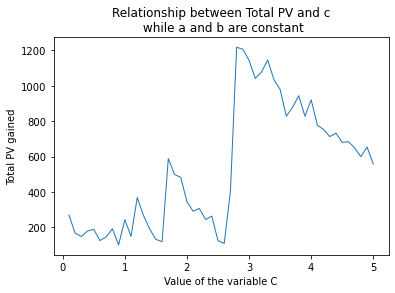

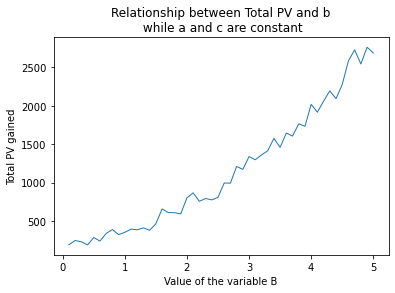

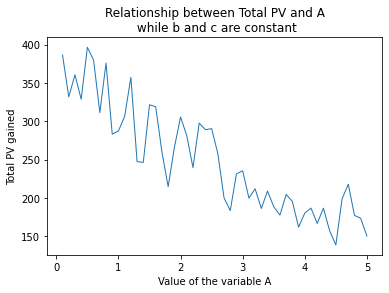

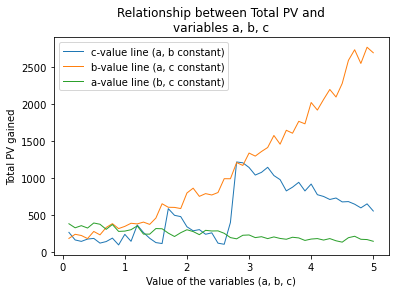

In [7]:
# 1) a and b will be constant while c will change from 0.1 to 5.0 in 0.1 steps
a, b = 1, 0.8
gained_pv_for_different_values_of_c = [] #this will be our results list
list_of_c_values = np.arange(0.1, 5.1, 0.1) # Using np.arange we generate a list of 50 different values of 'c' from 0.1 up to 5.0 inclusively

for c in list_of_c_values: #for loop for every step of c between 0.1 and 5
    trading_results = outcomes(1000, 10, a, b, c) #our outcomes function with 1000 traders with max pv of 10
    sum_of_gained_pv = sum(trading_results['gained_pv']) #we sum the gained pv for all 1000 traders
    gained_pv_for_different_values_of_c.append(sum_of_gained_pv) #add the sum of all pvs to the final list.
                                                                #at the end we have as many differnent pv sums as different values for c

# Plotting the results.
import matplotlib.pyplot as plt
plt.plot(list_of_c_values, gained_pv_for_different_values_of_c, linewidth=1) #different values of c on x axis, sum of pvs for different values of c on y axis
plt.ylabel('Total PV gained') #name y axis
plt.xlabel('Value of the variable C') #name x axis
plt.title('Relationship between Total PV and c\n while a and b are constant') #name the graph
plt.show() 

# 2) a and c will be constant while b will change from 0.1 to 5.0 in 0.1 steps

a, c = 1, 0.1
gained_pv_for_different_values_of_b = [] #this will be our results list
list_of_b_values = np.arange(0.1, 5.1, 0.1) # Using np.arange we generate a list of 50 different values of 'b' from 0.1 up to 5.0 inclusively

for b in list_of_b_values: #for loop for every step of b between 0.1 and 5
    trading_results = outcomes(1000, 10, a, b, c) #our outcomes function with 1000 traders with max pv of 10
    sum_of_gained_pv = sum(trading_results['gained_pv']) #we sum the gained pv for all 1000 traders
    gained_pv_for_different_values_of_b.append(sum_of_gained_pv) #add the sum of all pvs to the final list.
                                                                #at the end we have as many differnent pv sums as different values for c

# Plotting the results.
plt.plot(list_of_b_values, gained_pv_for_different_values_of_b, linewidth=1) #different values of c on x axis, sum of pvs for different values of c on y axis
plt.ylabel('Total PV gained') #name y axis
plt.xlabel('Value of the variable B') #name x axis
plt.title('Relationship between Total PV and b\n while a and c are constant') #name the graph
plt.show()

# 3) b and c will be constant while a will change from 0.1 to 5.0

b, c = 0.8, 0.1
gained_pv_for_different_values_of_a = [] #this will be our results list
list_of_a_values = np.arange(0.1, 5.1, 0.1) # Using np.arange we generate a list of 50 different values of 'a' from 0.1 up to 5.0 inclusively, with a step of 0.1.

for a in list_of_a_values: #for loop for every step of a between 0.1 and 5
    trading_results = outcomes(1000, 10, a, b, c) #our outcomes function with 1000 traders with max pv of 10
    sum_of_gained_pv = sum(trading_results['gained_pv']) #we sum the gained pv for all 1000 traders
    gained_pv_for_different_values_of_a.append(sum_of_gained_pv) #add the sum of all pvs to the final list.
                                                                #at the end we have as many differnent pv sums as different values for c

# Plotting the results.
plt.plot(list_of_a_values, gained_pv_for_different_values_of_a, linewidth=1) #different values of c on x axis, sum of pvs for different values of c on y axis
plt.ylabel('Total PV gained') #name the x axis
plt.xlabel('Value of the variable A') #name the x axis
plt.title('Relationship between Total PV and A\n while b and c are constant') #name the graph
plt.show()


# Plotting three lines on one graph for convenience
plt.plot(list_of_c_values, gained_pv_for_different_values_of_c, linewidth=1, label='c-value line (a, b constant)')
plt.plot(list_of_b_values, gained_pv_for_different_values_of_b, linewidth=1, label='b-value line (a, c constant)')
plt.plot(list_of_a_values, gained_pv_for_different_values_of_a, linewidth=1, label='a-value line (b, c constant)')
plt.ylabel('Total PV gained')
plt.xlabel('Value of the variables (a, b, c)')
plt.legend()
plt.title('Relationship between Total PV and\nvariables a, b, c')
plt.show()